In [1]:
%%capture
!pip install torch torch-geometric
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#!pip install pandas

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/posture1.csv', sep=',')

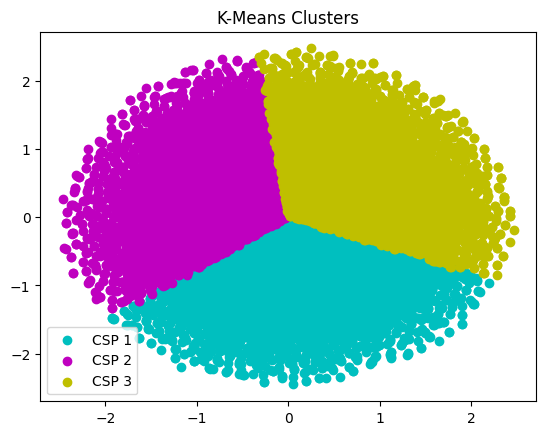

In [4]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scale = StandardScaler()
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

X = TSNE(n_components=2, random_state=42).fit_transform( df )
X_scaled=scale.fit_transform(X)

kmeans_clustering = KMeans( n_clusters = 3 ).fit( X_scaled )
colors = np.array([x for x in 'cmyk'])
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=colors[kmeans_clustering.labels_], label='CSP 1')
for i in range(kmeans_clustering.n_clusters):
    X_scaled1 = X_scaled[kmeans_clustering.labels_ == i]
    plt.scatter(X_scaled1[:, 0], X_scaled1[:, 1], c=colors[i], label=f'CSP {i + 1}')

plt.legend()
plt.title('K-Means Clusters')
plt.savefig("K-Means.png")
plt.show()

In [2]:
import dgl
import dgl.nn as dglnn
from dgl.nn import SAGEConv
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, roc_curve, f1_score, average_precision_score
import random
import networkx as nx
import time
from torch.utils.data.sampler import SubsetRandomSampler

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [5]:
object_columns = df.select_dtypes(include=[object]).columns
df[object_columns] = df[object_columns].apply(pd.to_numeric, errors='coerce')
features = torch.tensor(df.iloc[:].values, dtype=torch.float)
#print(features)
labels = torch.tensor(kmeans_clustering.labels_, dtype=torch.long)

graph = dgl.graph(([], []))

num_nodes = len(df)
graph.add_nodes(num_nodes)

if num_nodes > 1:

    for i in range(num_nodes):
        graph.add_edges(i, (i + 1) % num_nodes)
        graph.add_edges((i + 1) % num_nodes, i)

def add_random_edge(graph, num_nodes):
    source = random.randint(0, num_nodes - 1)
    target = random.randint(0, num_nodes - 1)
    if source != target:
        if random.choice([True, False]):
            graph.add_edges(source, target)
        else:
            #graph.add_edges(source, target)
            graph.add_edges(target, source)

num_interconnecting_edges = 1000

for _ in range(num_interconnecting_edges):
    add_random_edge(graph, num_nodes)

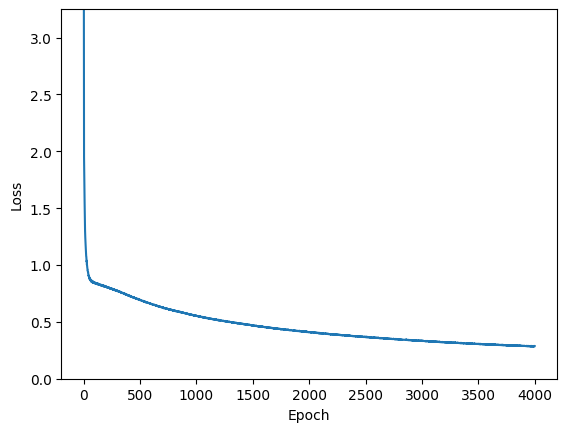

Average Training Time per Epoch: 0.35 seconds


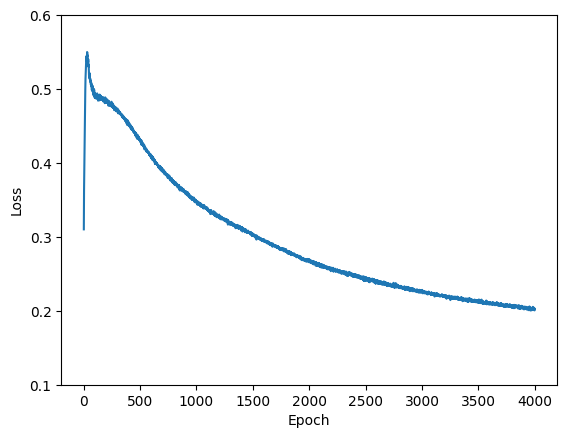

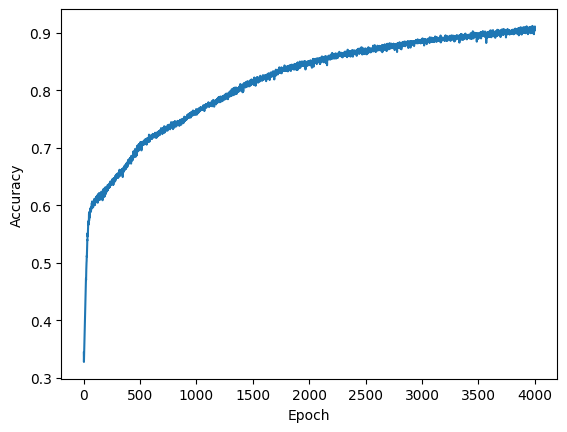

In [6]:
input_size = features.size(1)
hidden_size = 64
output_size = len(torch.unique(labels))

class GNN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size, 'mean')
        self.conv2 = SAGEConv(hidden_size, num_classes, 'mean')

    def forward(self, graph, features):
        x = self.conv1(graph, features)
        x = F.relu(x)
        x = self.conv2(graph, x)
        return x

num_train_nodes = int(0.7 * len(df))
train_idx = list(range(num_train_nodes))

num_test_nodes =  num_nodes - num_train_nodes
test_idx = list(range(num_test_nodes))

batch_size = 100
train_loader = GraphDataLoader(list(train_idx), batch_size=batch_size, shuffle=True)
test_loader = GraphDataLoader(list(test_idx), batch_size=batch_size, shuffle=True)

#print("Features shape:", features.shape)
#print("Graph nodes:", graph.number_of_nodes())
#print("Graph edges:", graph.number_of_edges())
#print(graph.edges())
unique_labels = torch.unique(labels)
#print("Unique Labels:", unique_labels)
#print("Number of Unique Labels:", len(unique_labels))

model = GNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

def train():
    model.train()
    #start_time = time.time()
    total_loss = 0
    for batched_train_idx in train_loader:
        optimizer.zero_grad()
        batched_graph = dgl.node_subgraph(graph, batched_train_idx)
        logits = model(batched_graph, features[batched_train_idx])
        loss = F.cross_entropy(logits, labels[batched_train_idx])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    #end_time = time.time()
    #training_time = end_time - start_time
    return total_loss / len(train_loader)

def test():
    model.eval()
    test_predictions = []
    predicted_probs =[]
    test_labels = []
    testing_loss = 0.0
    batch_indices = []
    with torch.no_grad():
        for batched_test_idx in test_loader:
            batch_indices.append(batched_test_idx)
            global test_graph
            test_graph = dgl.node_subgraph(graph, batched_test_idx)
            logits = model(test_graph, features[batched_test_idx])
            predicted_labels = torch.argmax(logits, dim=1).numpy()
            predicted_prob = F.softmax(logits, dim=1).numpy()
            test_predictions.extend(predicted_labels)
            predicted_probs.extend(predicted_prob)
            test_labels.extend(labels[batched_test_idx].numpy())
            test_labels_tensor = torch.tensor(predicted_labels, dtype=torch.long)
            testing_loss += F.cross_entropy(logits, test_labels_tensor).item()

    accuracy = accuracy_score(test_labels, test_predictions)
    testing_loss /= len(test_loader)

    return accuracy, testing_loss, test_predictions, batch_indices,predicted_probs

num_epochs = 4000
losses = []
accuracies = []
training_times = []
testing_losses = []
testing_predictions = []
for epoch in range(num_epochs):
    start_time = time.time()
    loss = train()
    end_time = time.time()
    epoch_time = end_time - start_time
    training_times.append(epoch_time)
    accuracy, testing_loss, test_predictions, batch_indices, predicted_probs = test()
    losses.append(loss)
    #training_times.append(training_time)
    accuracies.append(accuracy)
    testing_losses.append(testing_loss)
    testing_predictions.append(test_predictions)

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 3.25])
plt.savefig("Training Loss over Epochs.png")
plt.show()

average_epoch_time = sum(training_times) / num_epochs
print(f"Average Training Time per Epoch: {average_epoch_time:.2f} seconds")

plt.plot(range(1, num_epochs + 1), testing_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.1, 0.6])
plt.savefig("Test Loss over Epochs.png")
plt.show()

plt.plot(range(1, num_epochs + 1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("Test Accuracy over Epochs.png")
plt.show()

In [ ]:
batch_indices_tensor = torch.cat(batch_indices)
test_predictions_np = np.array(test_predictions)
predicted_probs_np=np.array(predicted_probs)

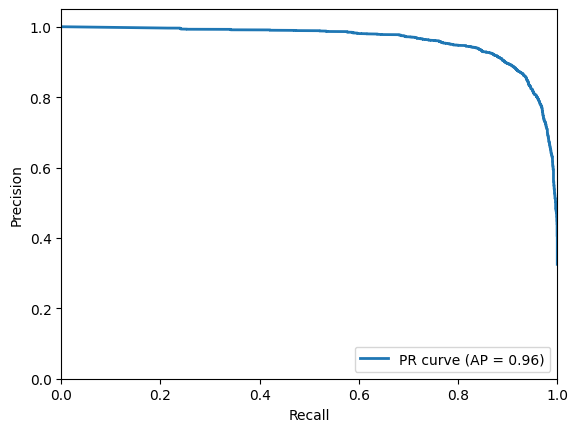

In [ ]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    class_labels = (labels[batch_indices_tensor] == i).numpy().astype(int)
    precision[i], recall[i], _ = precision_recall_curve(class_labels, predicted_probs_np[:, i])
    average_precision[i] = average_precision_score(class_labels, predicted_probs_np[:, i])

all_precision = np.unique(np.concatenate([precision[i] for i in range(output_size)]))
mean_recall = np.zeros_like(all_precision)
for i in range(output_size):
    mean_recall += np.interp(all_precision, precision[i], recall[i])
mean_recall /= output_size
overall_average_precision = np.mean([average_precision[i] for i in range(output_size)])

plt.plot(mean_recall, all_precision, lw=2, label='PR curve (AP = {0:0.2f})'.format(overall_average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.savefig("PR.png")
plt.show()

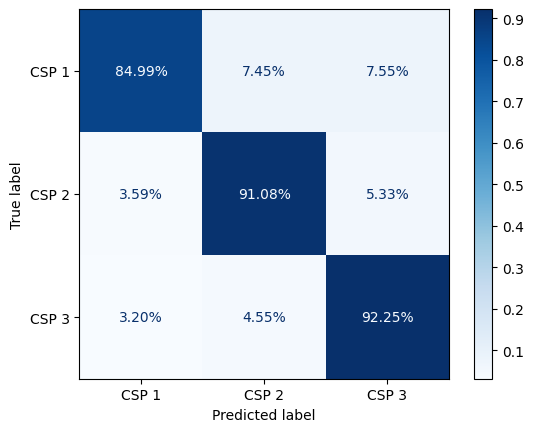

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(labels[batch_indices_tensor], test_predictions_np)
class_percentages = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(confusion_matrix=class_percentages, display_labels=["CSP 1", "CSP 2", "CSP 3"])

disp.plot(cmap=plt.cm.Blues, values_format='.2%')

plt.savefig("Confusion Matrix.png")
plt.show()

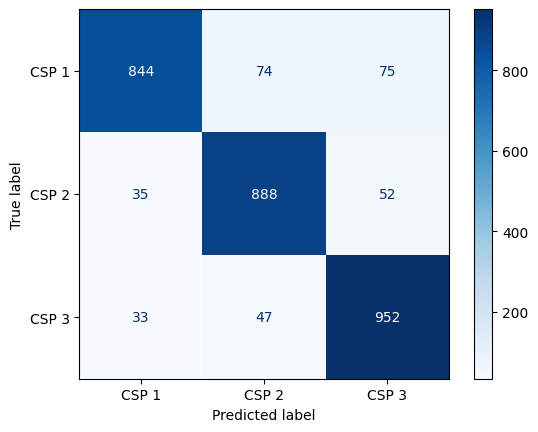

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(labels[batch_indices_tensor], test_predictions_np)
class_percentages = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["CSP 1", "CSP 2", "CSP 3"])

disp.plot(cmap=plt.cm.Blues)

plt.savefig("Confusion Matrix values.png")
plt.show()

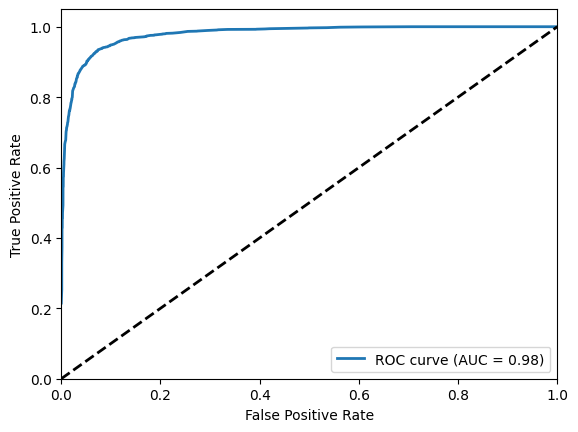

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    class_labels = (labels[batch_indices_tensor] == i).numpy().astype(int)
    fpr[i], tpr[i], _ = roc_curve(class_labels, predicted_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(output_size)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(output_size):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= output_size
overall_roc_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, lw=2, label='ROC curve (AUC = {0:0.2f})'.format(overall_roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig("ROC.png")
plt.show()